In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse import linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
%matplotlib notebook

In [3]:
# Planck's constant is set to 1 and the mass to 1/2
dt = 0.0002 #time step
N = 20000 #number of time steps

xi = -10.
xf = 10.
J = 5001 #number of space nodes
dx = (xf-xi)/(J-1) #space step

In [4]:
# setting up the potential
Xgrid = np.linspace(xi, xf, J)

def V(x):
    if x < 2 or x > 4:
        pot = 0
    else:
        pot = 10
    return pot

potential = np.zeros((J))
for i in range(J):
    potential[i] = V(xi+i*dx)

In [5]:
Psi = np.zeros((N,J), complex) # this array will store the wave function

# we need to specify the intial Psi values
k0 = 2.5
m = 0.5
sigma0 = 1
center = -5
Psi[0,:] = 1/(sigma0**2*np.pi)**(1/4)*np.exp((1j)*k0*Xgrid-(Xgrid-center)**2/(2*sigma0**2))

In [6]:
q = k0/m
c1 = 1/q
c2 = q/4

zeta1 = -(1j)/(2*dx) - (1j)*c1/(2*dt) + (c1*V(xf)-c2)/4
zeta2 = (1j)/(2*dx) - (1j)*c1/(2*dt) + (c1*V(xf)-c2)/4
zeta3 = (1j)/(2*dx) - (1j)*c1/(2*dt) - (c1*V(xf)-c2)/4
zeta4 = -(1j)/(2*dx) - (1j)*c1/(2*dt) - (c1*V(xf)-c2)/4
zeta = np.array([0, zeta1, zeta2, zeta3, zeta4])

In [7]:
# setting up the tridiagonal matrices
ones = np.ones((J), complex)
alpha = (1j)*dt/(2*dx**2)*ones
xis = np.zeros((J), complex)
for i in range(J):
    xis[i] = 1 + (1j)*dt/2*(2/(dx**2) + potential[i])
xis[0] = zeta[1]
xis[J-1] = zeta[1]
up = -alpha*ones
down = -alpha*ones
up[1] = zeta[2]
down[J-2] = zeta[2]
gamma = np.zeros((J), complex)
for i in range(J):
    gamma[i] = 1 - (1j)*dt/2*(2/(dx**2) + potential[i])
gamma[0] = zeta[3]
gamma[J-1] = zeta[3]
ups = alpha*ones
downs = alpha*ones
ups[1] = zeta[4]
downs[J-2] = zeta[4]

In [8]:
diags = np.array([-1, 0, 1])
vecs1 = np.array([down, xis, up])
vecs2 = np.array([downs, gamma, ups])

U1 = sp.spdiags(vecs1, diags, J, J)
U1 = U1.tocsc()
U2 = sp.spdiags(vecs2, diags, J, J)

In [9]:
LU = linalg.splu(U1)
for n in range(N-1):
    b = U2.dot(Psi[n,:])
    Psi[n+1,:] = LU.solve(b)

In [10]:
# Lets get the complex conjugate and the probability density
Psi_star = np.conj(Psi)

Density = Psi*Psi_star
Density = np.abs(Density) #Lets eliminate the zero imaginary parts

In [11]:
"""
fig, ax = plt.subplots()

line, = ax.plot(Xgrid, Density[0,:])


def animate(i):   
    line.set_ydata(Density[i,:])  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(Xgrid, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, N), init_func=init,
                              interval=1, blit=True)
plt.show()
"""

'\nfig, ax = plt.subplots()\n\nline, = ax.plot(Xgrid, Density[0,:])\n\n\ndef animate(i):   \n    line.set_ydata(Density[i,:])  # update the data\n    return line,\n\n\n# Init only required for blitting to give a clean slate.\ndef init():\n    line.set_ydata(np.ma.array(Xgrid, mask=True))\n    return line,\n\nani = animation.FuncAnimation(fig, animate, np.arange(1, N), init_func=init,\n                              interval=1, blit=True)\nplt.show()\n'

In [12]:
'''
plt.figure() #this figure shows the potential
plt.plot(Xgrid, potential, 'g')
plt.show()
'''

"\nplt.figure() #this figure shows the potential\nplt.plot(Xgrid, potential, 'g')\nplt.show()\n"

In [13]:
# we need a little subroutine to compute derivatives
# dim carries the dimension along which we will differentiate
def derivative(array, dim, dd):
    leng = array.shape[dim]
    der = np.zeros_like(array)
    for i in range(1, leng-1):
        indxl = [Ellipsis]*array.ndim
        indx = [Ellipsis]*array.ndim
        indxr = [Ellipsis]*array.ndim
        indxl[dim] = i-1
        indx[dim] = i
        indxr[dim] = i+1
        der[indx] = (array[indxr]-array[indxl])/(2*dd)
    indx0 = [Ellipsis]*array.ndim
    indx1 = [Ellipsis]*array.ndim
    indx0[dim] = 0
    indx1[dim] = 1
    der[indx0] = (array[indx1]-array[indx0])/dd
    indxm1 = [Ellipsis]*array.ndim
    indxm2 = [Ellipsis]*array.ndim
    indxm1[dim] = -1
    indxm2[dim] = -2
    der[indxm1] = (array[indxm1]-array[indxm2])/dd
    
    return der

In [14]:
# Now lets compute the trajectories
S = np.angle(Psi)
for i in range(N):
    S[i,:] = np.unwrap(S[i,:])

In [15]:
v = np.zeros((N,J)) # this array contains the velocity field

In [16]:
v = derivative(S, 1, m*dx)

In [17]:
nt = 50 #this is how many trajectories will be shown
x = np.zeros((nt, N))
x[:,0] = np.linspace(center-2, center+2, nt)
# x[:,0] = np.random.normal(center, sigma0, nt)

In [18]:
for l in range(nt):
    # compute the current location of the particle on the grid
    for i in range(1,N):
        loca = (x[l,i-1]-xi)/dx #this is the location on the grid
        k = np.int(np.floor(loca))
        if k > J-2:
            x[l,i:N] = xf + 10 # After a particle reaches the end it is disappeared
            break
        elif k < 0:
            x[l,i:N] = xi - 10 # Disappeared
            break
        else:
            x[l,i] = x[l,i-1] + (v[i-1,k]*(loca-k)+v[i-1,k+1]*(1-loca+k))*dt

<IPython.core.display.Javascript object>


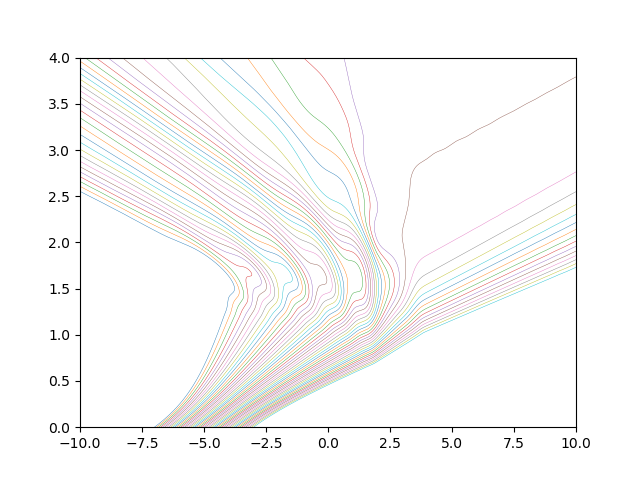

In [19]:
Tgrid = np.linspace(0, N*dt, N)

plt.figure()
plt.axis([xi, xf, 0, N*dt])
for l in range(nt):
    plt.plot(x[l,:],Tgrid, linewidth=0.3)
plt.show()